In [29]:
import pickle
import os

os.environ['CUDA_VISIBLE_DEVICES'] = f''

import numpy as np
import matplotlib.pyplot as plt

# import jax
# from jax.config import config
# config.update("jax_enable_x64", True)  # crucial for Gaussian processes
# import jax.random as jrnd
# import jax.numpy as jnp
# import distrax as dx

def plt_stylelize():
    plt.rc('axes', titlesize=18)        # fontsize of the axes title
    plt.rc('axes', labelsize=16)        # fontsize of the x and y labels
    plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
    plt.rc('legend', fontsize=16)       # legend fontsize
    plt.rc('figure', titlesize=20)      # fontsize of the figure title
    plt.style.use('Solarize_Light2')
plt_stylelize()

## load data
Collect all results by loading each pickle file within a specified results folder.

In [30]:
def get_files_paths(file_name, path):
    """
    Finds all `file_name` within `path` including subfolders
        and returns a list with complete file path per found file.
    """
    found_paths = []
    for root, _, files in os.walk(path):
        filtered_files = list(
            filter(lambda fname: file_name == fname, files))
        if len(filtered_files) == 1:
            found_paths.append(root + '/' + filtered_files[0])
    
    return found_paths

def load_pickles(paths):
    """
    Loads a bunch pickles located at `paths`,
        unpickles and returns their content in a list ready for serving.
    """
    vars = []
    for path in paths:
        with open(path, 'rb') as file: 
            vars.append(pickle.load(file))
    return vars

#path = './results_sparse_gp_test/2023-12-14_14-39_full-test_40-inducing_1000_100-smc_gp_std-Data_normal-Z/'
# path = './results_sparse_gp_test/2023-12-14_15-18_full-test_40-inducing_1000_100-smc_chirp_std-Data_normal-Z/'
# path = './results_sparse_gp_test/2023-12-14_15-18_full-test_40-inducing_1000_100-smc_square_std-Data_normal-Z/'

# path = './results_sparse_gp_test/2023-12-14_17-41_full-test_100-inducing_1000_100-smc_chirp_std-Data_normal-Z/'
#path = './results_sparse_gp_test/2023-12-14_17-41_full-test_100-inducing_1000_100-smc_gp_std-Data_normal-Z/'
# path = './results_sparse_gp_test/2023-12-14_17-41_full-test_100-inducing_1000_100-smc_square_std-Data_normal-Z/'

#path = './results_sparse_gp_test/2023-12-15_10-19_full-test_40-inducing_1000_200-smc_chirp_std-Data/'
#path = './results_sparse_gp_test/2023-12-15_10-19_full-test_40-inducing_1000_200-smc_gp_std-Data/'
#path = './results_sparse_gp_test/2023-12-15_10-19_full-test_40-inducing_1000_200-smc_square_std-Data/'

path = './results_sparse_gp_test/2023-12-15_10-19_full-test_40-inducing_1000_200-smc_gp_std-Data/sparseGP_seed_404367952/'

(1, 1000, 100)
(1, 1000, 100)


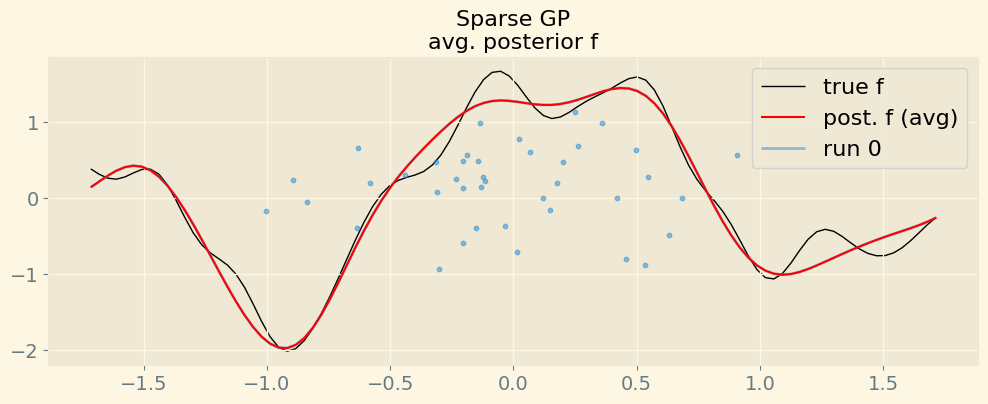

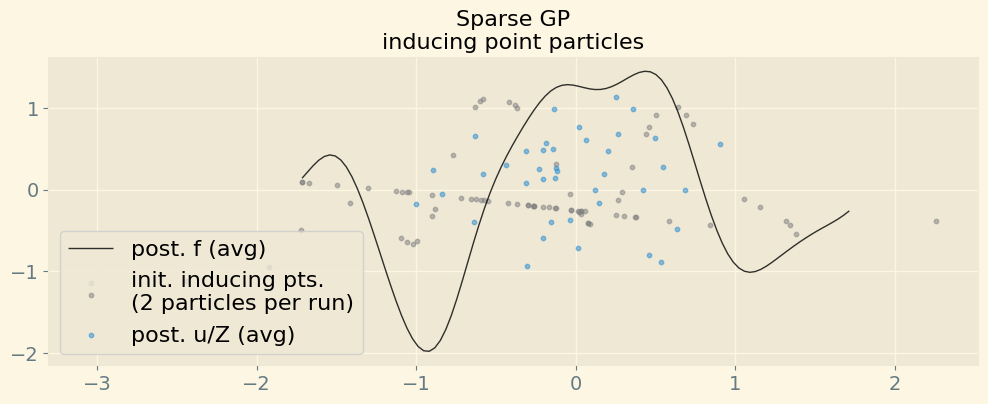

In [31]:
# combine all particles in numpy arrays to compute averages easier
# resulting shape (num_runs, num_particles, num_variables per variable)

data = dict(
    x = None,
    y = None,
    ground_truth = None,
    initial_particles = None,
    particles = None,
    marginal_likelihood=None)

for k in data:
     filtered_files = list(
            filter(lambda fname: 'sparseGP' in fname, get_files_paths(f'{k}.pickle', path)))
     data[k] = load_pickles(filtered_files)

particles = dict(
    f = None,
    u = None,
    Z = None)
num_runs = len(data['particles'])
for k in particles:
    num_particles, num_variables = data['particles'][0].particles[k].shape
    particles[k] = np.zeros((num_runs, num_particles, num_variables))
    for i in range(num_runs):
        particles[k][i] = data['particles'][i].particles[k]
print(particles['f'].shape)


init_particles = dict(
    f = None,
    u = None,
    Z = None)
num_runs = len(data['initial_particles'])
for k in init_particles:
    num_particles, num_variables = data['initial_particles'][0].position[k].shape
    init_particles[k] = np.zeros((num_runs, num_particles, num_variables))
    for i in range(num_runs):
        init_particles[k][i] = data['initial_particles'][i].position[k]
print(init_particles['f'].shape)


# plot posterior f
plt.figure(figsize=(12, 4))
plt.plot(
    data['x'][0].flatten(), 
    data['ground_truth'][0]['f'], 
    label=f'true f', color='black', linewidth=1, alpha=1, zorder=-1)

f_mean_per_run = np.mean(particles['f'], axis=1)
f_mean = np.mean(f_mean_per_run, axis=0)
plt.plot(
    data['x'][0].flatten(), f_mean, 
    label=f'post. f (avg)', color='red', linewidth=1.5, alpha=1, zorder=5)
for i in range(num_runs):
    plt.plot(
        data['x'][0].flatten(), f_mean_per_run[i, :],
        label=f'run {i}', 
        linewidth=2, alpha=.5)

    Z_mean_per_run = np.mean(particles['Z'], axis=1)
    u_mean_per_run = np.mean(particles['u'], axis=1)
    plt.scatter(
        Z_mean_per_run[i, :], u_mean_per_run[i, :], 
        #label=f'run {i}' if i==0 else "",
        alpha=0.5, s=10)
plt.title(f'Sparse GP\navg. posterior f')
plt.legend()
plt.savefig(path + 'result_sparseGP_avg-f.png')
plt.show()



# plot inducing points
plt.figure(figsize=(12, 4))
f_mean_per_run = np.mean(particles['f'], axis=1)
f_mean = np.mean(f_mean_per_run, axis=0)
plt.plot(
    data['x'][0].flatten(), f_mean, 
    label=f'post. f (avg)', color='black', linewidth=1, alpha=.8)

for i in range(num_runs):
    # init_Z_mean_per_run = np.mean(init_particles['Z'], axis=1)
    # init_u_mean_per_run = np.mean(init_particles['u'], axis=1)
    num_random_particles = 2
    rnd_particle = np.random.randint(0, 1000, num_random_particles)
    init_Z_mean_per_run = init_particles['Z'][:, rnd_particle, :]
    init_u_mean_per_run = init_particles['u'][:, rnd_particle, :]
    plt.scatter(
        init_Z_mean_per_run[i, :], init_u_mean_per_run[i, :], 
        alpha=0.5, s=10, color='grey',
        label=f'init. inducing pts.\n({num_random_particles} particles per run)' if i==0 else "") 
    
    Z_mean_per_run = np.mean(particles['Z'], axis=1)
    u_mean_per_run = np.mean(particles['u'], axis=1)
    plt.scatter(
        Z_mean_per_run[i, :], u_mean_per_run[i, :], 
        label=f'post. u/Z (avg)' if i==0 else "",
        alpha=0.5, s=10)
plt.title(f'Sparse GP\ninducing point particles')
plt.legend()
plt.savefig(path + 'result_sparseGP_inducing-particles.png')
plt.show()

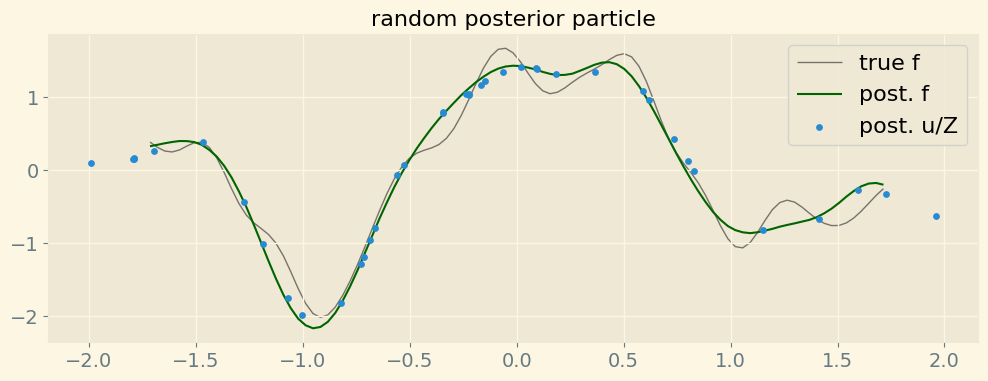

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(
    data['x'][0].flatten(), 
    data['ground_truth'][0]['f'], 
    label=f'true f', color='black', linewidth=1, alpha=.5, zorder=-1)

num_random_particles = 1
rnd_particle_idx = np.random.randint(0, 1000, num_random_particles)

for i in rnd_particle_idx:
    plt.plot(
        data['x'][0].flatten(), particles['f'][0, i, :],
        color='darkgreen', linewidth=1.5, alpha=1, zorder=1,
        label=f'post. f')
    
    plt.scatter(
        particles['Z'][0, i, :],  particles['u'][0, i, :],
        alpha=1, s=15, zorder=2,
        label=f'post. u/Z')
plt.title('random posterior particle')
plt.legend()
plt.show()

In [33]:

data = dict(
    x = None,
    y = None,
    ground_truth = None,
    initial_particles = None,
    particles = None,
    marginal_likelihood=None)

for k in data:
     filtered_files = list(
            filter(lambda fname: 'latentGP' in fname, get_files_paths(f'{k}.pickle', path)))
     data[k] = load_pickles(filtered_files)

particles = dict(
    f = None)
num_runs = len(data['particles'])
for k in particles:
    num_particles, num_variables = data['particles'][0].particles[k].shape
    particles[k] = np.zeros((num_runs, num_particles, num_variables))
    for i in range(num_runs):
        particles[k][i] = data['particles'][i].particles[k]
print(particles['f'].shape)


init_particles = dict(
    f = None)
num_runs = len(data['initial_particles'])
for k in init_particles:
    num_particles, num_variables = data['initial_particles'][0].position[k].shape
    init_particles[k] = np.zeros((num_runs, num_particles, num_variables))
    for i in range(num_runs):
        init_particles[k][i] = data['initial_particles'][i].position[k]
print(init_particles['f'].shape)


# plot posterior f
plt.figure(figsize=(12, 4))
plt.plot(
    data['x'][0].flatten(), 
    data['ground_truth'][0]['f'], 
    label=f'true f', color='black', linewidth=1, alpha=1, zorder=-1)

f_mean_per_run = np.mean(particles['f'], axis=1)
f_mean = np.mean(f_mean_per_run, axis=0)
plt.plot(
    data['x'][0].flatten(), f_mean, 
    label=f'post. f (avg)', color='red', linewidth=1.5, alpha=1, zorder=5)
for i in range(num_runs):
    plt.plot(
        data['x'][0].flatten(), f_mean_per_run[i, :],
        label=f'run {i}', 
        linewidth=2, alpha=.5)
    plt.scatter(
        data['x'][0].flatten(), data['y'][0].flatten(), 
        #label=f'run {i}' if i==0 else "",
        alpha=0.5, s=10)
plt.title(f'Latent GP\navg. posterior f')
plt.legend()
plt.savefig(path + 'result_latentGP_avg-f.png')
plt.show()

IndexError: list index out of range

In [ ]:
# from sprase_gp_test import plot_smc

# plot_smc(
#     data['x'][0],
#     data['y'][0],
#     data['particles'][0].particles,
#     data['ground_truth'][0],
#     f'average_{len(data["x"])}_seeds',
#     folder=path)